In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.backends.backend_pdf import PdfPages

from sys import path
path.append("../src")
from utils import save_pickle

In [2]:
SCENARIOS = {
    1: {"DATA_SOURCES": ["darknet", "honeypot"]},
    2: {"DATA_SOURCES": ["darknet"]},
    3: {"DATA_SOURCES": ["honeypot"]},
    4: {"DATA_SOURCES": ["darknet"]},
    5: {"DATA_SOURCES": ["honeypot"]},
}

stacking_strategies = ["igcngru_features", "idarkvec", "features"]
stacking_strategies.sort()
STRATS_POSFIX = "-".join(stacking_strategies)

In [3]:
labels = [
    "censys",
    "driftnet",
    "internetcensus",
    "intrinsec",
    "ipip",
    "mirai",
    "onyphe",
    "rapid7",
    "securitytrails",
    "shadowserver",
    "shodan",
    "u_mich",
    "unk_bruteforcer",
    "unk_exploiter",
    "unk_spammer",
    "unknown",
]

labels.sort()

In [4]:
with open(f"../data/2022/output/darknet/{STRATS_POSFIX}/2/report/k3.pkl", "rb") as fd:
    stacking_reporte = pickle.load(fd)

In [5]:
def plot_cm(y, preds, labels):
    cm = confusion_matrix(y, preds, labels=labels, normalize="true")
    # cm = np.trunc(1000 * cm) / 1000
    sns.set(font_scale=1.2)  # Adjust font scale for better visibility
    sns.heatmap(
        cm,
        annot=True,
        annot_kws={"size": 12},
        xticklabels=labels,
        yticklabels=labels,
        square=False,
    )
    return cm


def get_y_preds(stacking_reporte, day):
    y, preds = [], []
    for fold in stacking_reporte[day]:
        y.append(stacking_reporte[day][fold]["y"])
        preds.append(stacking_reporte[day][fold]["preds"])

    y = np.hstack(y)
    preds = np.hstack(preds)

    return y, preds

Text(0.5, 1.0, 'Day: 20221021')

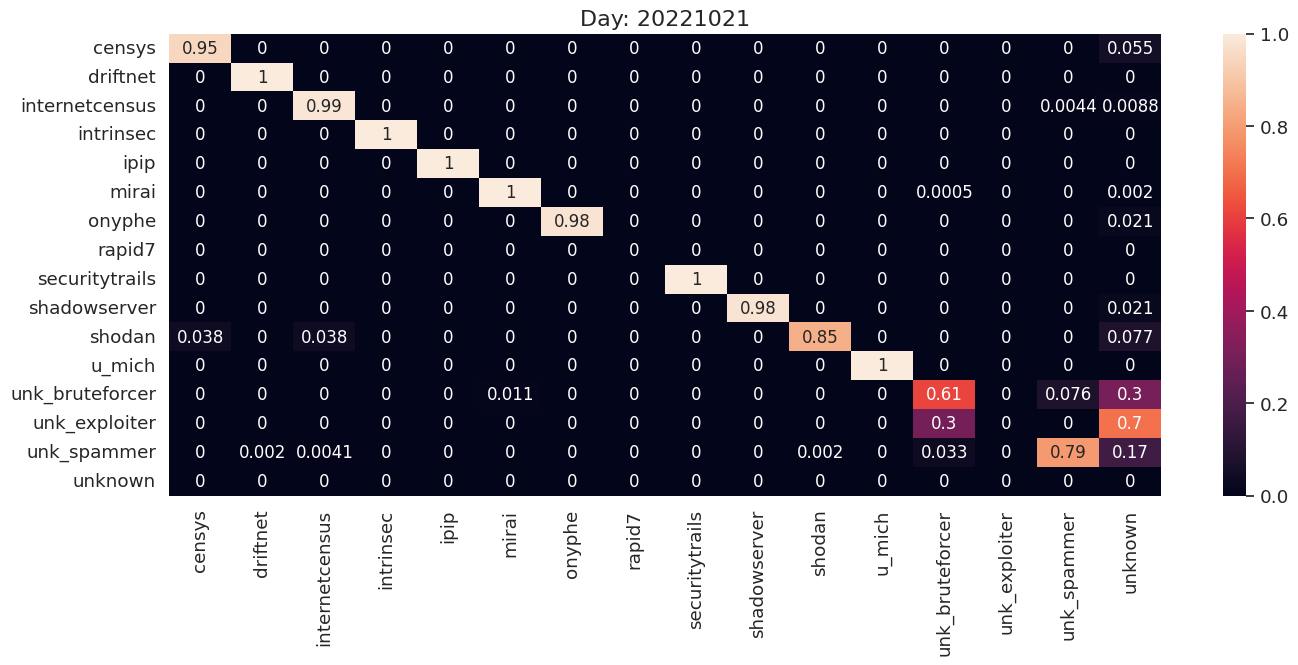

In [6]:
plt.figure(figsize=(16, 6))
day = "20221021"
y, preds = get_y_preds(stacking_reporte, day)
_ = plot_cm(y, preds, labels)
plt.title(f"Day: {day}", fontsize=16)

In [7]:
for case in SCENARIOS:
    case_sources = SCENARIOS[case]["DATA_SOURCES"]
    data_source_sufix = '-'.join(case_sources)
    # Create a PDF file to save the plots
    with PdfPages(f"../pdfs/charts/cms/{data_source_sufix}_{case}.pdf") as pdf:
        for plot_idx, day in enumerate(stacking_reporte):
            with open(f"../data/2022/output/{data_source_sufix}/{STRATS_POSFIX}/{case}/report/k3.pkl", "rb") as fd:
                stacking_reporte = pickle.load(fd)
                plt.figure(figsize=(12, 6))
                y, preds = get_y_preds(stacking_reporte, day)
                cm = plot_cm(y, preds, labels)
                plt.title(f"Day: {day}", fontsize=16)
                plt.tight_layout()
                pdf.savefig(bbox_inches="tight")
                plt.close()

            out = {"cm": cm, "labels": labels}
            ddir = f"../data/logs/cms/{case}/{day}"
            os.makedirs(ddir, exist_ok=True)
            save_pickle(out, f"{ddir}/cm.pkl")